# Sng retrieval

## Setup

In [1]:
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import logging
logger = logging.getLogger()
np.random.seed(42)

## Model

In [2]:
from tramp.experiments import TeacherStudentScenario
from tramp.models import SngRetrieval

In [3]:
sng_retrieval = SngRetrieval(N=100, alpha=2.0, ensemble_type="gaussian", mean_prior=1)
print(f"sng_retrieval = {sng_retrieval}")

sng_retrieval = SngRetrieval(
  ensemble=GaussianEnsemble(M=200,N=100),
  prior=GaussianPrior(size=100,mean=1,var=1),
  linear=LinearChannel(W_name=F,Nx=200,Nz=100,ravel=False,precompute_svd=True),
  output=AbsChannel()
)


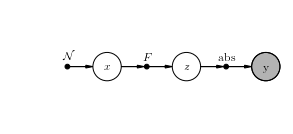

In [4]:
scenario = TeacherStudentScenario(sng_retrieval)
scenario.setup()
scenario.student.daft()

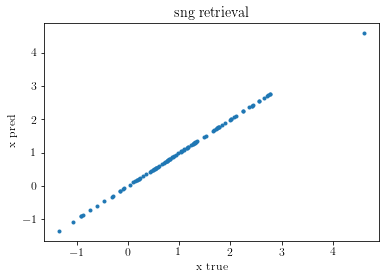

In [5]:
# checking that it can predict negative values also
scenario.infer()

fig, ax = plt.subplots(1,1)
ax.plot(scenario.x_true["x"], scenario.x_pred["x"],'.')
ax.set(title="sng retrieval", xlabel="x true", ylabel="x pred");

## Experiments

In [6]:
def run_sng_retrieval(N, alpha, ensemble_type, mean_prior):
    sng_retrieval = SngRetrieval(N, alpha, ensemble_type, mean_prior)
    scenario = TeacherStudentScenario(sng_retrieval)
    scenario.setup()
    scenario.infer()
    return dict(
        mse_ep=scenario.mse_ep["x"], n_iter_ep=scenario.n_iter_ep,
        mse_se=scenario.mse_se["x"], n_iter_se=scenario.n_iter_se,
        mse=scenario.mse["x"]
    )

In [7]:
from ml_physics_utils import Task, DataFrameResultHandler
from ml_physics_utils.notebook import progressbar
from ml_physics_utils.plot import qplot
logger.setLevel(logging.ERROR)

csv_file = "../data/sng_retrieval_experiments.csv"

def run_experiments():
    result_handler = DataFrameResultHandler()
    task = Task(
        run_sng_retrieval, 
        N=1000, ensemble_type="gaussian",
        mean_prior=[-1, 0.5, 1, 2], alpha=np.linspace(0,2,100)[1:]
    )
    with progressbar() as on_progress:
        task.run(result_handler, on_progress)
    df = result_handler.get_dataframe()
    df.to_csv(csv_file, index=False)
    return df

In [8]:
try:
    df = pd.read_csv(csv_file)
except FileNotFoundError:
    df = run_experiments()

## Phase transition

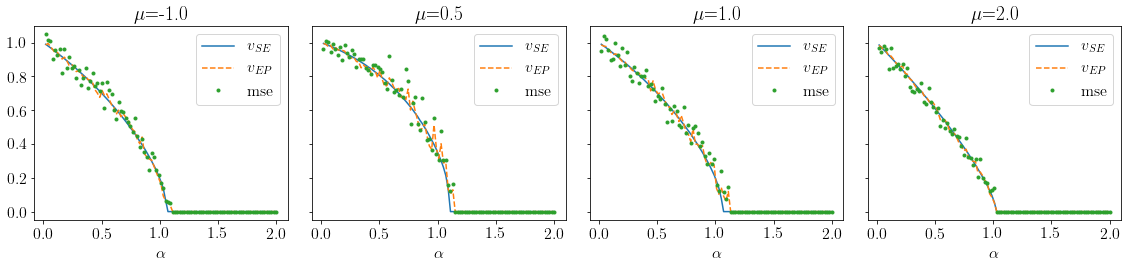

In [9]:
qplot(
    df, 
    x="alpha", y=["mse_se", "mse_ep", "mse"], y_markers=["-","--", "."], column="mean_prior", y_legend=True,
    rename={"mse_se":r"$v_{SE}$", "mse_ep":r"$v_{EP}$", "alpha":r"$\alpha$", "mean_prior":r"$\mu$"},
    usetex=True, font_size=16
)

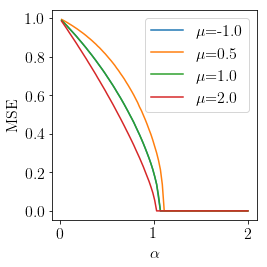

In [10]:
qplot(
    df, 
    x="alpha", y="mse_se", color="mean_prior",
    rename={"mse_se":"MSE", "alpha":r"$\alpha$", "mean_prior":r"$\mu$"},
    usetex=True, font_size=16
)

## Nbr of iterations diverging at the critical value

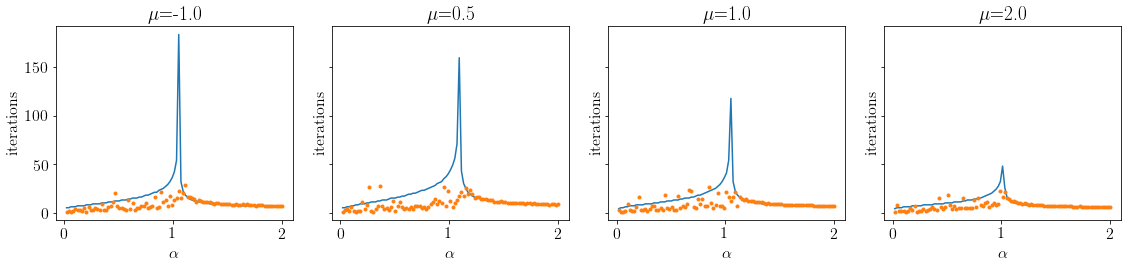

In [11]:
qplot(
    df, 
    x="alpha", y=["n_iter_se","n_iter_ep"], y_markers=["-","."], column="mean_prior",
    rename={"n_iter_se, n_iter_ep":"iterations", "alpha":r"$\alpha$", "mean_prior":r"$\mu$"},
    usetex=True, font_size=16
)